In [17]:
# Importar las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer el dataset
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')

In [18]:
df.shape

(2443651, 9)

In [19]:
print(df.columns)


Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')


In [20]:
# Mostrar las primeras filas para conocer el contenido
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


## Create a Crosstab Analysis / Crear un Análisis de Tabla de Contingencia

In [21]:
# Crear una tabla de contingencia entre la categoría del producto y si es un best seller
crosstab = pd.crosstab(df['category'], df['isBestSeller'])
print(crosstab)

# Calcular la proporción de best-sellers para cada categoría
crosstab['Proporción de Best-Sellers'] = crosstab[True] / crosstab.sum(axis=1)

# Ordenar las categorías según la proporción de best-sellers en orden descendente
sorted_crosstab = crosstab.sort_values('Proporción de Best-Sellers', ascending=False)
print(sorted_crosstab)


isBestSeller                    False  True 
category                                    
3D Printers                       247      1
3D Printing & Scanning           4065      2
Abrasive & Finishing Products     245      5
Action Cameras                   1696      1
Adapters                          251      3
...                               ...    ...
Wind Instruments                  243      7
Window Treatments                 234      5
Women                           17559    213
Women's Sports & Outdoor Shoes   1939     20
eBook Readers & Accessories       246      0

[296 rows x 2 columns]
isBestSeller                      False  True  Proporción de Best-Sellers
category                                                                 
Grocery                            9008   556                    0.058135
Smart Home Security & Lighting       98     6                    0.057692
Health & Personal Care             9017   552                    0.057686
Mobile Phone Accessor

## Chi-square Test

In [22]:
from scipy.stats import chi2_contingency

# Realizar la prueba de Chi-cuadrado
chi2, p, _, _ = chi2_contingency(crosstab)

# Imprimir el estadístico Chi-cuadrado y el valor p
print(f'Estadístico Chi-cuadrado: {chi2}, valor p: {p}')


Estadístico Chi-cuadrado: 36684.23786636857, valor p: 0.0


## Cramér's V

In [23]:
import numpy as np
from scipy.stats import chi2_contingency

# Función para calcular Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]  # Usar el resultado de la prueba de Chi-cuadrado
    n = confusion_matrix.sum().sum()  # Sumar todos los valores en la matriz de confusión
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))  # Calcular Cramér's V

# Crear la tabla de contingencia entre la categoría del producto y isBestSeller
crosstab = pd.crosstab(df['category'], df['isBestSeller'])

# Calcular el estadístico de Cramér's V
cramers_v_stat = cramers_v(crosstab)
print(f'Cramér\'s V: {cramers_v_stat}')


Cramér's V: 0.1222829439760564


## Visualizations

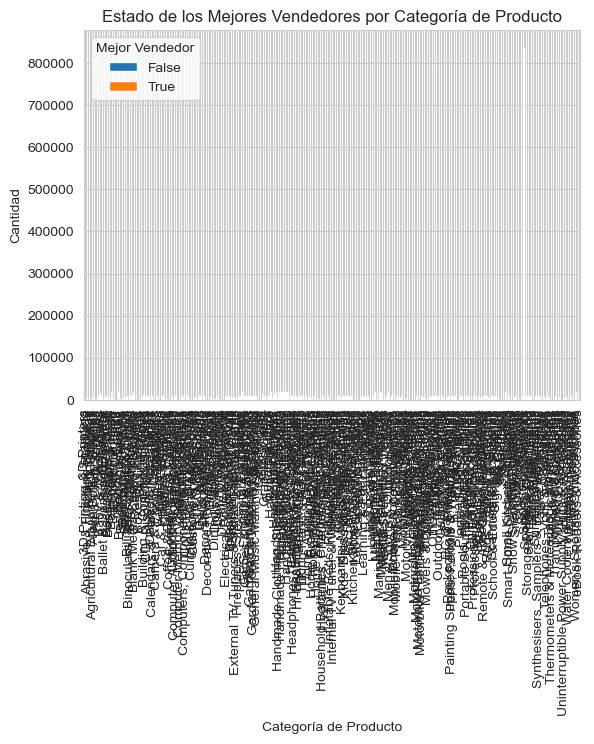

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de barras apiladas
crosstab.plot(kind='bar', stacked=True)
plt.title('Estado de los Mejores Vendedores por Categoría de Producto')  # Título del gráfico
plt.xlabel('Categoría de Producto')  # Etiqueta del eje X
plt.ylabel('Cantidad')  # Etiqueta del eje Y
plt.legend(title='Mejor Vendedor')  # Título de la leyenda
plt.show()  # Muestra el gráfico


## Exploring Product Prices and Ratings Across Categories and Brands / Explorando los precios y calificaciones de productos a través de categorías y marcas

# Eliminar valores atípicos en los precios de los productos

In [25]:
# Calcular Q1 (percentil 25) y Q3 (percentil 75)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Filtrar y eliminar los valores atípicos
df_no_outliers = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]

# Imprimir el número de filas antes y después de eliminar los valores atípicos
print(f"Número de filas antes de eliminar outliers: {len(df)}")
print(f"Número de filas después de eliminar outliers: {len(df_no_outliers)}")


Número de filas antes de eliminar outliers: 2443651
Número de filas después de eliminar outliers: 2115963


## Violin Plots

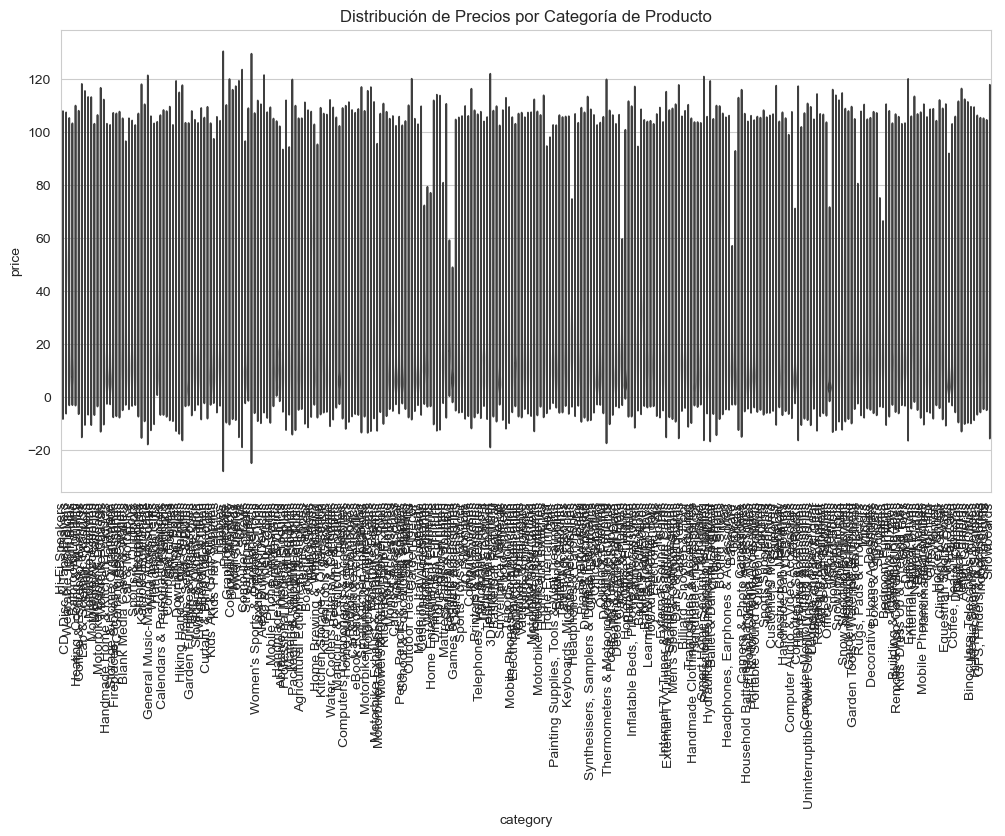

Categoría con el precio medio más alto: Desktop PCs


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de violín de la distribución de precios a través de las categorías de productos
plt.figure(figsize=(12, 6))
sns.violinplot(x='category', y='price', data=df_no_outliers, inner='quartile')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=90)

# Añadir título
plt.title('Distribución de Precios por Categoría de Producto')

# Mostrar el gráfico
plt.show()

# Encontrar la categoría con el precio medio más alto
highest_median_price_category = df_no_outliers.groupby('category')['price'].median().idxmax()
print(f'Categoría con el precio medio más alto: {highest_median_price_category}')


## Bar Charts

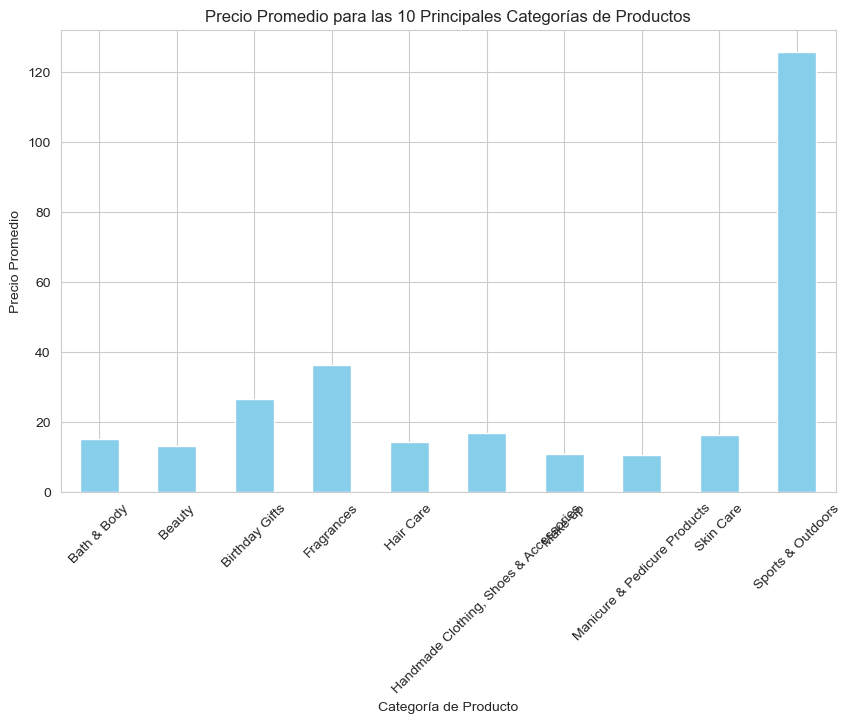

In [27]:
# Gráfico de barras comparando el precio promedio de las 10 principales categorías de productos
# Obtener las 10 categorías con más productos
top_10_categories = df['category'].value_counts().nlargest(10).index

# Calcular el precio promedio para las 10 categorías principales
avg_price_top_10 = df[df['category'].isin(top_10_categories)].groupby('category')['price'].mean()

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
avg_price_top_10.plot(kind='bar', color='skyblue')

# Añadir título y etiquetas
plt.title('Precio Promedio para las 10 Principales Categorías de Productos')
plt.xlabel('Categoría de Producto')
plt.ylabel('Precio Promedio')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()


## Box Plots

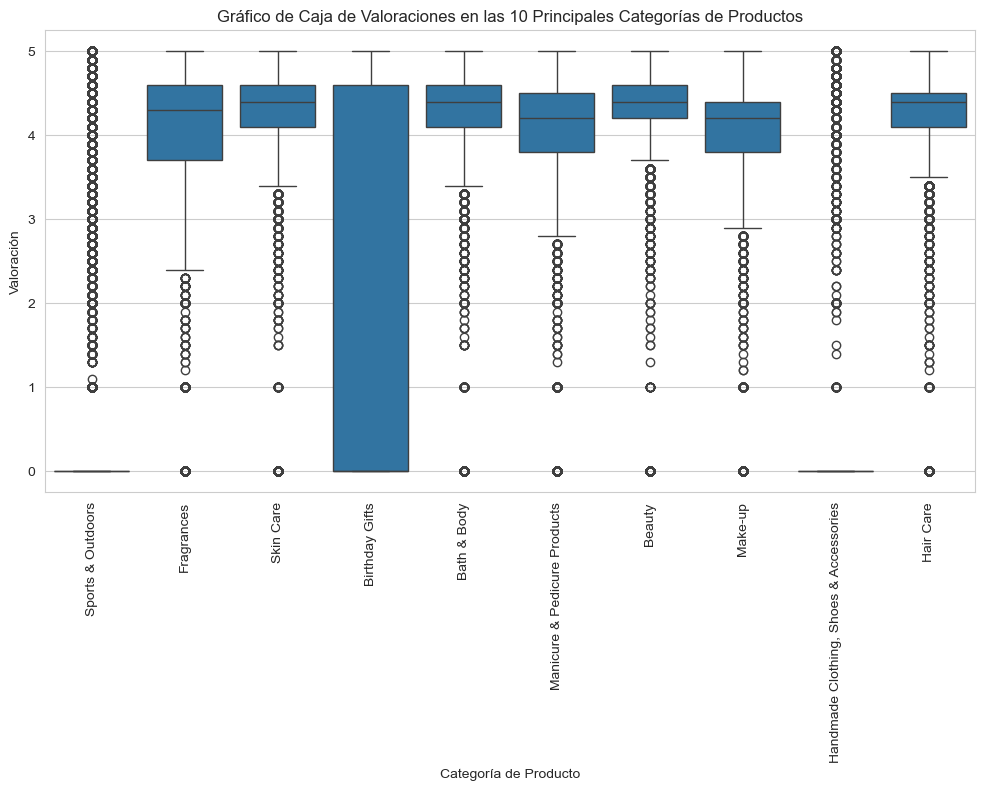

In [28]:
# Box plots para las valoraciones de productos a través de categorías
# Obtener las 10 categorías con más productos
top_10_categories_ratings = df['category'].value_counts().nlargest(10).index

# Crear un gráfico de caja
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='stars', data=df[df['category'].isin(top_10_categories_ratings)])

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=90)

# Añadir título y etiquetas
plt.title('Gráfico de Caja de Valoraciones en las 10 Principales Categorías de Productos')
plt.xlabel('Categoría de Producto')
plt.ylabel('Valoración')

# Mostrar el gráfico
plt.show()


# Investigating the Interplay Between Product Prices and Ratings / Investigando la Interacción entre los Precios de los Productos y las Valoraciones

In [29]:
# Calcular el coeficiente de correlación entre precio y valoraciones (ratings)
correlation = df['price'].corr(df['stars'])
print(f'Correlación entre Precio y Valoraciones: {correlation}')


Correlación entre Precio y Valoraciones: -0.12490673262159059


In [30]:
# Verificar los tipos de datos de cada columna
print("Tipos de datos en cada columna:")
print(df.dtypes)

# Verificar si hay valores no numéricos en el DataFrame
non_numeric_columns = df.select_dtypes(exclude=['number']).columns
print("Columnas no numéricas:", non_numeric_columns)

# Mostrar las filas con valores no numéricos en estas columnas
for col in non_numeric_columns:
    print(f"Valores únicos en la columna {col}:", df[col].unique())


Tipos de datos en cada columna:
uid                    int64
asin                  object
title                 object
stars                float64
reviews                int64
price                float64
isBestSeller            bool
boughtInLastMonth      int64
category              object
dtype: object
Columnas no numéricas: Index(['asin', 'title', 'isBestSeller', 'category'], dtype='object')
Valores únicos en la columna asin: ['B09B96TG33' 'B01HTH3C8S' 'B09B8YWXDF' ... 'B0BD5FL5FB' 'B008OYLL4I'
 'B08P3W9B3T']
Valores únicos en la columna title: ['Echo Dot (5th generation, 2022 release) | Big vibrant sound Wi-Fi and Bluetooth smart speaker with Alexa | Charcoal'
 'Anker Soundcore mini, Super-Portable Bluetooth Speaker with 15-Hour Playtime, 66-Foot Bluetooth Range, Wireless Speaker with Enhanced Bass, Noise-Cancelling Microphone, for Outdoor, Travel, Home'
 'Echo Dot (5th generation, 2022 release) | Big vibrant sound Wi-Fi and Bluetooth smart speaker with Alexa | Deep Sea Blue'
 ...

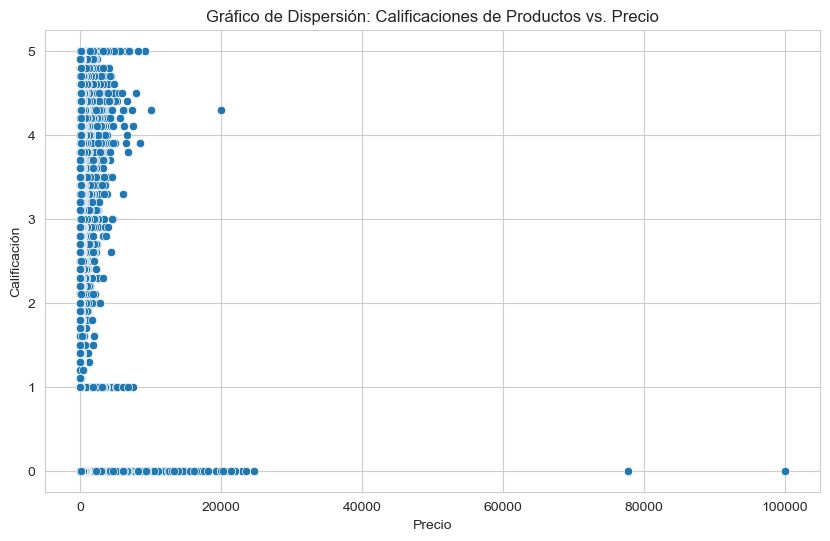

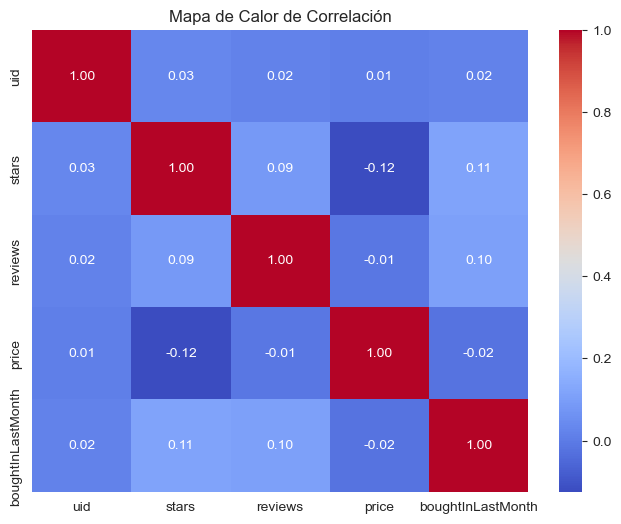

<Figure size 800x600 with 0 Axes>

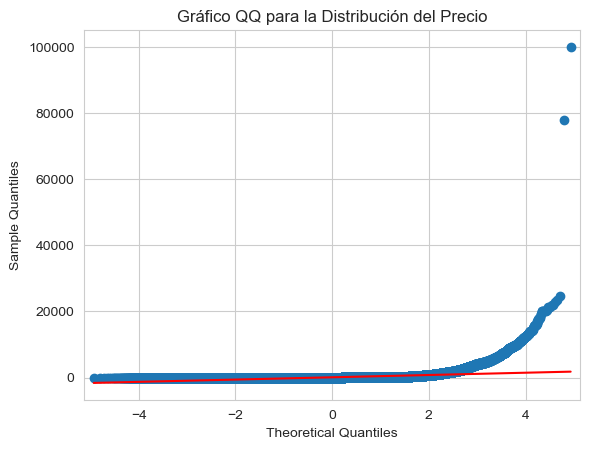

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# Establecer el estilo de Seaborn
sns.set_style('whitegrid')

# Eliminar filas con valores nulos en las columnas 'price' y 'stars'
df = df.dropna(subset=['price', 'stars'])

# Filtrar solo las columnas numéricas para la matriz de correlación
df_numeric = df.select_dtypes(include=['number'])

# Gráfico de dispersión de las calificaciones de productos frente al precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='stars', data=df)
plt.title('Gráfico de Dispersión: Calificaciones de Productos vs. Precio')
plt.xlabel('Precio')
plt.ylabel('Calificación')
plt.show()

# Mapa de calor de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de Calor de Correlación')
plt.show()

# Gráfico QQ para la distribución del precio
plt.figure(figsize=(8, 6))
sm.qqplot(df['price'], line='s')
plt.title('Gráfico QQ para la Distribución del Precio')
plt.show()
